In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../')
from ml_functions import *

def preparedf(path):
    dfraw = pd.read_csv(path)
    labels = dfraw['Menopause']
    df = dfraw.iloc[:, 2:]
    return df, labels

train_df, train_labels = preparedf('../../steps/train_df_meno.csv')
test_df, test_labels = preparedf('../../steps/test_df_meno.csv')

### SCALING ###
from sklearn.preprocessing import StandardScaler, MinMaxScaler
stand_scaler, mm_scaler = StandardScaler(), MinMaxScaler()

stand_scaler.fit(train_df)
mm_scaler.fit(train_df)

train_df_stand, test_df_stand = stand_scaler.transform(train_df), stand_scaler.transform(test_df)
train_df_minmax, test_df_minmax = mm_scaler.transform(train_df), mm_scaler.transform(test_df)

from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [22]:
rs = 26
# SVM 
svc_mod = SVC(C = 110, gamma = 'auto', kernel = 'poly', degree = 2, random_state=rs, probability=True)

# Logistic regression 
log_mod = LogisticRegression(penalty = 'l2', solver = 'lbfgs', C = 1, random_state=rs)

# LDA
lda_mod = LinearDiscriminantAnalysis(shrinkage = 'auto', solver = 'lsqr')

# QDA
qda_mod = QuadraticDiscriminantAnalysis(reg_param = 0.75)

# Gradient Boosting 
gr_mod = GradientBoostingClassifier(learning_rate = 1, max_depth = 4, max_features = 0.775, 
                                    min_samples_leaf = 35, min_samples_split = 10, n_estimators = 1000, subsample = 1, random_state = rs)

# Adaptive Boosting
ada_mod = AdaBoostClassifier(n_estimators = 800, learning_rate = 0.01, random_state = rs)

# XGBoost
xgb_mod = XGBClassifier(colsample_bynode = 0.55, colsample_bytree= 0.1, learning_rate = 2, 
                        max_depth = 2, n_estimators = 1000, reg_lambda = 10, subsample = 0.325, random_state=rs)

# RandomForest
rf_mod = RandomForestClassifier(bootstrap = True, max_depth = 6, max_features = 0.8, 
                                min_samples_leaf = 5, min_samples_split = 15, n_estimators = 1000, random_state=rs)

### PCA ###
pca = PCA(svd_solver = 'full')
pca.fit(train_df_stand)
train_pcs = pca.transform(train_df_stand)
test_pcs = pca.transform(test_df_stand)

# pca-lda
pca_lda = LinearDiscriminantAnalysis(shrinkage = 0.6, solver = 'lsqr')
pca_lda.fit(train_pcs, train_labels)


# pca_qda
pca_qda = QuadraticDiscriminantAnalysis(reg_param = 0.875)
pca_qda.fit(train_pcs[:, 0:20], train_labels)

# KNN
knn_mod = KNeighborsClassifier(n_neighbors = 5, algorithm = 'auto', weights = 'uniform')

In [23]:
models = [svc_mod, log_mod, lda_mod, qda_mod, gr_mod, ada_mod, xgb_mod, rf_mod, knn_mod]
model_names = ['SVM', 'LogReg', 'LDA', 'QDA', 'GrBoost', 'AdaBoost', 'XGBoost', 'RF', 'KNN']

# Fitting all the non-pca models
for model in models:
    model.fit(train_df_minmax, train_labels)

/home/tomas/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [6]:
def ensemble_feature_importances(model, n = 10, rs = 26):
    """This is for `unstable` methods that generate different model each time they are called - ensemble tree methods"""
    importances = []
    for i in range(n):
        model.set_params(**{'random_state':i}) # change random state
        model.fit(train_df_minmax, train_labels) # train model
        importances.append(list(model.feature_importances_)) # append feature importances

    return np.mean(importances, axis = 0)

In [10]:
features_ms = pd.DataFrame({
    'LoR':log_mod.coef_[0],
    'LDA':lda_mod.coef_[0],
    'GrB':ensemble_feature_importances(gr_mod),
    'Ada':ensemble_feature_importances(ada_mod),
    'XGB':ensemble_feature_importances(xgb_mod),
    'RnF':ensemble_feature_importances(rf_mod)
}, index = list(train_df))

features_ms = features_ms.sort_index()
features_ms.head()

,LoR,LDA,GrB,Ada,XGB,RnF
"1,5-Anhydro-D-sorbitol TMS4",-0.096736,-1.701251,0.0,0.0,0.000000,0.000122
2-Hydroxy-3-methyl-butyric acid TMS2,-0.086107,-0.260215,0.0,0.0,0.000000,0.000074
2-Hydroxy-pyridine TMS,0.044155,-1.699121,0.0,0.0,0.000610,0.000009
2-Keto-4-methyl-valeric acid MEOX-TMS,-0.009453,1.308973,0.0,0.0,0.002232,0.000071
3-Hydroxy-3-methyl-butyric acid TMS2,-0.002939,-3.550223,0.0,0.0,0.000735,0.000036


In [11]:
def rank_features(df, i):
    tempdf = pd.DataFrame(np.abs(df.iloc[:,i]).sort_values(ascending = False)) # sort coefficients
    tempdf['Ranking'] = np.arange(len(tempdf)) # rank them
    return np.array(tempdf.sort_index()['Ranking']) # return just the rank - and making sure that row indices in input and output match

In [12]:
rankings = []
for i in range(features_ms.shape[1]):
    rankings.append(rank_features(features_ms, i))
    
ranking_df = pd.DataFrame(np.array(rankings).T, columns = np.array(features_ms.columns), index = np.array(features_ms.index))

best_features_ms = pd.DataFrame({'Median_rank':np.median(ranking_df, axis=1)}, index = ranking_df.index).sort_values('Median_rank',ascending = True)[:15]
best_features_ms

,Median_rank
unknown 4.02,3.5
unknown 1.20,4.5
Unknown 0368 (trace analyte),11.5
Hydroxy-sphingomyelin C22:1,12.0
unknown 3.88,13.0
unknown 1.72,15.5
Ornithine,15.5
unknown 3.95,15.5
Choline,16.5
unknown 2.12,17.5


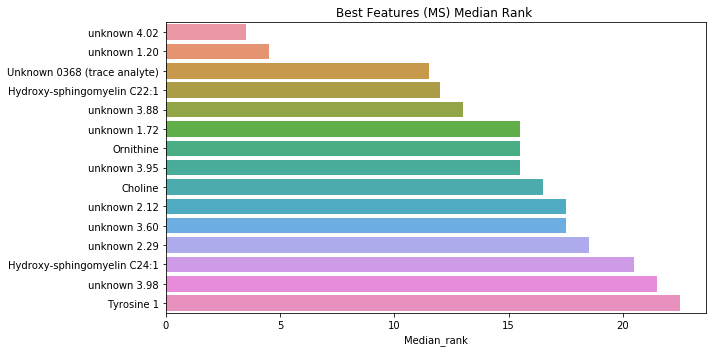

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(y = best_features_ms.index, x = best_features_ms.Median_rank)
plt.title('Best Features (MS) Median Rank ')
plt.tight_layout()
plt.savefig('../../plots/MS_prediction/best_features_ms.png', dpi = 150)

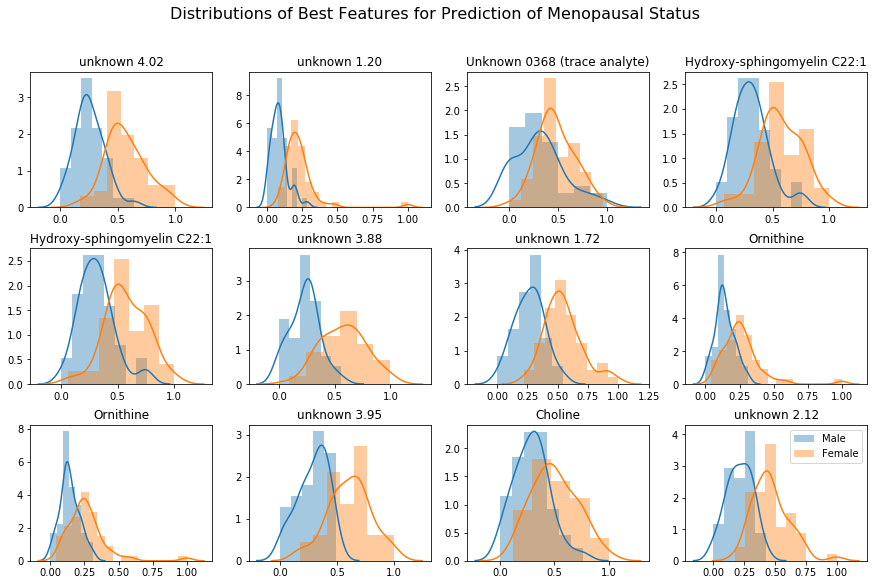

In [19]:
fig, ax = plt.subplots(3, 4, figsize = (15, 9))

for i in range(3):
    for j in range(4):
        ind = list(train_df).index(best_features_ms.index[3*i+j])
        sns.distplot(train_df_minmax[:, ind][train_labels == 1], label = 'Male', ax = ax[i, j])
        sns.distplot(train_df_minmax[:, ind][train_labels == 2], label = 'Female', ax = ax[i, j])
        #ax[i, j].legend()
        ax[i, j].set_title(best_features_ms.index[3*i+j])
ax[2, 3].legend()
plt.subplots_adjust(hspace = 0.3)
fig.suptitle('Distributions of Best Features for Prediction of Menopausal Status', size = 16)
plt.savefig('../../plots/MS_prediction/best_features_distributions_ms.png', dpi = 200);

In [20]:
def model_confidence(model, df, labels, title, axi = None):
    prob_predict = model.predict_proba(df)
    prob_predict[:, 1] = -prob_predict[:, 1] + 1 
    
    probs = []
    for i in range(len(prob_predict)):
        m = np.argmax([prob_predict[i, 0], np.abs(prob_predict[i, 1])])
        probs.append(prob_predict[i, m])
        
    yax = np.random.rand(len(probs))
    
    if axi is None:
        plt.axvspan(0.5, 1, alpha = 0.2)
        plt.axvspan(0, 0.5, alpha = 0.2, color = 'red')
        plt.plot(np.array(probs)[labels == 1], yax[labels == 1], '.', markersize = 10)
        plt.plot(np.array(probs)[labels == 2], yax[labels == 2], '.', color = 'red', markersize = 10)

        plt.yticks([])
    else:
        ax[axi[0], axi[1]].axvspan(0.5, 1, alpha = 0.1)
        ax[axi[0], axi[1]].axvspan(0, 0.5, alpha = 0.1, color = 'red')
        ax[axi[0], axi[1]].plot(np.array(probs)[labels == 1], yax[labels == 1], '.', markersize = 10, alpha = 0.3)
        ax[axi[0], axi[1]].plot(np.array(probs)[labels == 2], yax[labels == 2], '.', color = 'red', markersize = 10, alpha = 0.3)
        ax[axi[0], axi[1]].axes.yaxis.set_ticklabels([])
        ax[axi[0], axi[1]].set_title(title)

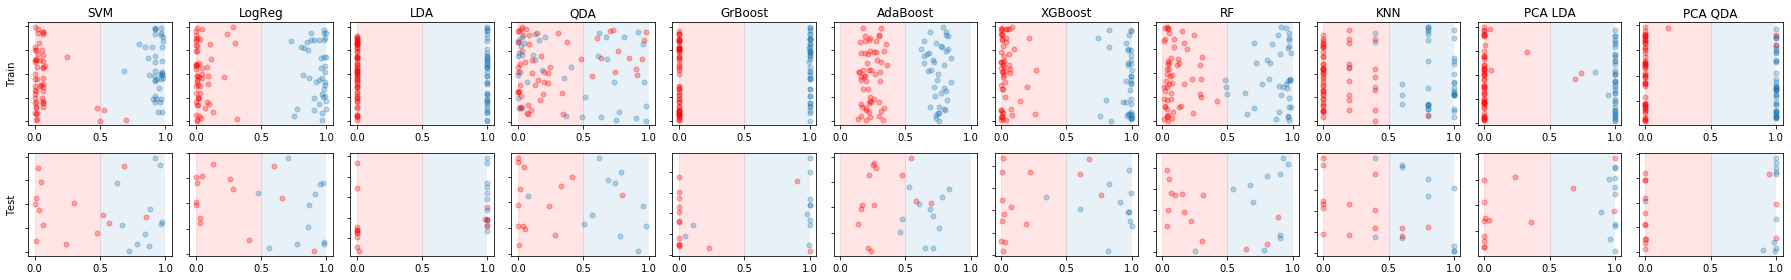

In [26]:
fig, ax = plt.subplots(2, 11, figsize = (25, 4))

for i, model in enumerate(models):
    model_confidence(model, train_df_minmax, train_labels, f'{model_names[i]}', axi = [0, i])

for i, model in enumerate(models):
    model_confidence(model, test_df_minmax, test_labels, '', axi = [1, i])

model_confidence(pca_lda, train_pcs[:, :96], train_labels, 'PCA LDA', axi = [0, 9])
model_confidence(pca_lda, test_pcs[:, :96], test_labels, '', axi = [1, 9])

model_confidence(pca_qda, train_pcs[:, :20], train_labels, 'PCA QDA', axi = [0, 10])
model_confidence(pca_qda, test_pcs[:, :20], test_labels, '', axi = [1, 10])

ax[0, 0].set_ylabel('Train')
ax[1, 0].set_ylabel('Test')

plt.tight_layout()
plt.savefig('../../plots/MS_prediction/model_confidence_ms.png', dpi = 200)

In [29]:
np.unique(train_labels, return_counts=True)

(array([1, 2]), array([40, 56]))